# Tutorial
Learn how to use the *Mira-Titan* HMF emulator.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import MiraTitanHMFemulator

print("Version", MiraTitanHMFemulator.__version__)

Version 0.0.0


## Initialize the emulator
This may take a few seconds: the code pre-computes a bunch of matrix inversions (actually, Cholesky decompositions).

In [2]:
HMFemu = MiraTitanHMFemulator.Emulator()

## Input cosmology
Let's define a set of cosmology parameter for which we want the HMF. In case you are unsure about the parameters and their ranges, you can grab that from the emulator instance we just created. Don't worry, the emulator will check that your cosmology is valid (see example "Validation of input cosmology" below).

In [3]:
HMFemu.param_limits

{'Ommh2': (0.12, 0.155),
 'Ombh2': (0.0215, 0.0235),
 'Omnuh2': (0, 0.01),
 'n_s': (0.85, 1.05),
 'h': (0.55, 0.85),
 'sigma_8': (0.7, 0.9),
 'w_0': (-1.3, -0.7),
 'w_a': (-1.73, 1.28),
 'w_b': (0.3, 1.3)}

### Note about dark energy equation-of-state parametrization
The emulator itself works in the space of $(w_0, w_b)$, where $w_b = (-w_0 -w_a)^{1/4}$ (see paper). The user is expected to provide the parameters in the usual space of $(w_0, w_a)$ and the code will handle the conversion for you!

Note that the cosmology needs to satisfy all 9 parameter constraints, not just 8 for the parameters you provided.

In [4]:
fiducial_cosmo = {'Ommh2': .3*.7**2,
                  'Ombh2': .022,
                  'Omnuh2': .0006,
                  'n_s': .96,
                  'h': .7,
                  'w_0': -1,
                  'w_a': 0,
                  'sigma_8': .8,
                 }

## Call the emulator
It's as easy as:

In [5]:
res = HMFemu.predict(fiducial_cosmo)

Now let's look at the output stored in the `res` dictionary. Each (numerical) key corresponds to a redshift for which the emulator computed the HMF. There's a `Units` key, too.

In [6]:
print(res.keys())

dict_keys(['Units', 2.02, 1.61, 1.01, 0.656, 0.434, 0.242, 0.101, 0.0])


In [7]:
print(res['Units'])

log10_M is log10(Mass in [Msun/h]), HMFs are given in dn/dlnM [(h/Mpc)^3]


So far, nothing too surprising. Now let's look into one of the redshift outputs:

In [8]:
print("Keys of res[0.0]:\t", res[0.0].keys())
print("Redshift of res[0.0]:\t", res[0.0]['redshift'])
print("Array of (log) masses:\t", res[0.0]['log10_M'])
print("The emulated HMF\t", res[0.0]['HMF'])

Keys of res[0.0]:	 dict_keys(['redshift', 'log10_M', 'HMF'])
Redshift of res[0.0]:	 0.0
Array of (log) masses:	 [13.    13.001 13.002 ... 15.797 15.798 15.799]
The emulated HMF	 [3.58216702e-04 3.57405814e-04 3.56596762e-04 ... 1.42782592e-11
 1.40608088e-11 1.38465487e-11]


This cries for a nice plot. Note that the emulator covers the HMF down to about 1e-12, which corresponds to different masses at different redshifts.

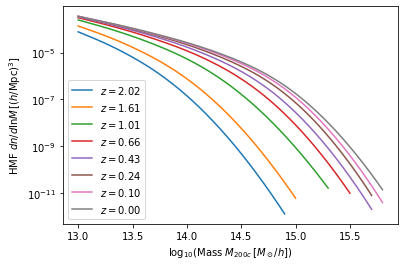

In [9]:
for z in HMFemu.z_arr:
    plt.semilogy(res[z]['log10_M'], res[z]['HMF'], label='$z=%.2f$'%z)
plt.xlabel('$\log_{10}$(Mass $M_{200c}\,[M_\odot/h]$)')
plt.ylabel('HMF $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')
plt.legend();

OK, now we understand the basic concept. Let's try another cosmology with dynamical dark energy just for fun.

In [10]:
w0wa_cosmo = {'Ommh2': .3*.7**2,
            'Ombh2': .022,
            'Omnuh2': .0006,
            'n_s': .96,
            'h': .7,
            'w_0': -1.3,
            'w_a': -1,
            'sigma_8': .8,
           }

In [11]:
res_w0wa = HMFemu.predict(w0wa_cosmo)

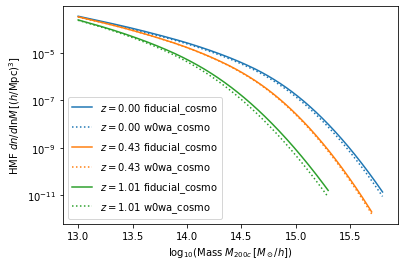

In [12]:
colors=['C%s'%i for i in range(3)]
for i,z in enumerate([0.0, 0.434, 1.01]):
    plt.semilogy(res[z]['log10_M'], res[z]['HMF'], color=colors[i], label='$z=%.2f$ fiducial_cosmo'%z)
    plt.semilogy(res[z]['log10_M'], res_w0wa[z]['HMF'], color=colors[i], label='$z=%.2f$ w0wa_cosmo'%z, ls=':')
plt.xlabel('$\log_{10}$(Mass $M_{200c}\,[M_\odot/h]$)')
plt.ylabel('HMF $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')
plt.legend();

## Validation of input cosmology
As mentioned earlier, the emulator validates your input cosmology. For example, if you miss one parameter, you get:

In [13]:
bad_cosmo = {'Ommh2': .3*.7**2,
             'Ombh2': .022,
             'Omnuh2': .0006,
             'n_s': .96,
             'h': .7,
             'w_0': -1,
             'w_a': 0,
#              'sigma_8': .8,
            }

try:
    HMFemu.predict(bad_cosmo)
except Exception as e:
    print(repr(e))

KeyError('You did not provide sigma_8',)


Or if you set a parameter outside the range:

In [14]:
bad_cosmo = {'Ommh2': .3*.7**2,
             'Ombh2': .022,
             'Omnuh2': .0006,
             'n_s': .96,
             'h': .7,
             'w_0': -1,
             'w_a': 0,
             'sigma_8': 1.8,
            }

try:
    HMFemu.predict(bad_cosmo)
except Exception as e:
    print(repr(e))

ValueError('Parameter sigma_8 is 1.8000 but must be <= 0.9000',)


If you don't want the emulator to raise an exception, for example because you are running an MCMC chain, you can also validate your input cosmology before calling the emulator:

In [15]:
is_valid = HMFemu.validate_params(bad_cosmo)
print("Input cosmology 'bad_cosmo' is valid: %s"%is_valid)

Input cosmology 'bad_cosmo' is valid: False


In [16]:
is_valid = HMFemu.validate_params(fiducial_cosmo)
print("Input cosmology 'fiducial_cosmo' is valid: %s"%is_valid)

Input cosmology 'fiducial_cosmo' is valid: True


## Emulator uncertainty
Now let's look at the built-in error estimate on the emulated HMF. Set `N_draw` to some reasonably large number such that the sample size is large enough to allow for robust error estimates. The output dictionary now has additional keys `HMF_mean` and `HMF_std`.

In [17]:
res_w_err = HMFemu.predict(fiducial_cosmo, N_draw=1000)
print(res_w_err[0.0].keys())

dict_keys(['redshift', 'log10_M', 'HMF', 'HMF_mean', 'HMF_std'])


Let's visualize the error on the emulated HMF. As expected, the noise increases with mass and redshift, because the input HMFs are limited by shot noise (and sample variance at low mass) in the halo catalogs.

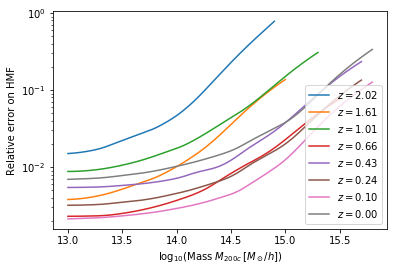

In [18]:
for i,z in enumerate(HMFemu.z_arr):
    plt.semilogy(res[z]['log10_M'], res_w_err[z]['HMF_std'], color='C%d'%i, label='$z=%.2f$'%z)
plt.xlabel('$\log_{10}$(Mass $M_{200c}\,[M_\odot/h]$)')
plt.ylabel('Relative error on HMF')
plt.legend(loc='lower right');

Also note that the emulator precision depends on the location in parameter space: If an input model is "close", the error is smaller than if the closest input cosmology is "far away". So let's compare the errors on the fiducial cosmology and the dynamical dark energy model:

In [19]:
res_w0wa_w_err = HMFemu.predict(w0wa_cosmo, N_draw=1000)

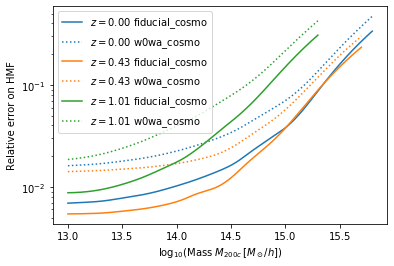

In [20]:
for i,z in enumerate([0.0, 0.434, 1.01]):
    plt.semilogy(res_w_err[z]['log10_M'], res_w_err[z]['HMF_std'],
                 color=colors[i], label='$z=%.2f$ fiducial_cosmo'%z)
    plt.semilogy(res_w0wa_w_err[z]['log10_M'], res_w0wa_w_err[z]['HMF_std'],
                 ls=':', color=colors[i], label='$z=%.2f$ w0wa_cosmo'%z)
plt.xlabel('$\log_{10}$(Mass $M_{200c}\,[M_\odot/h]$)')
plt.ylabel('Relative error on HMF')
plt.legend();

# Redshift evolution
The emulator provides the HMF for 8 discrete redshifts. If you need the HMF at some intermediate redshift, we recommend you simply interpolate. Let's look at the evolution of the HMF with redshift at fixed mass.

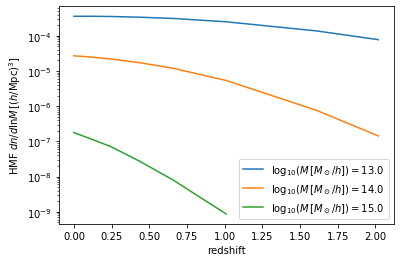

In [21]:
for m in [0, 1000]:
    plt.semilogy(HMFemu.z_arr, [res[z]['HMF'][m] for z in HMFemu.z_arr],
                 label='$\log_{10}(M\,[M_\odot/h])=%.1f$'%res[0.0]['log10_M'][m])
m = 2000
plt.semilogy(HMFemu.z_arr[2:], [res[z]['HMF'][m] for z in HMFemu.z_arr[2:]],
             label='$\log_{10}(M\,[M_\odot/h])=%.1f$'%res[0.0]['log10_M'][m],
            )

plt.xlabel('redshift')
plt.ylabel('HMF $dn/d\lnM\,[(h/\\mathrm{Mpc})^3]$')
plt.legend();

# That's it!
You now know how to use the *Mira-Titan* HMF emulator. Please don't hesitate to share your feedback!